<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/wildfires_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!rm -rf Validation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/Test.zip"
!unzip "/content/gdrive/My Drive/Training.zip"

In [3]:
import os 
import random
import shutil

In [4]:
os.mkdir('Validation')
os.mkdir('Validation/Fire')
os.mkdir('Validation/No_Fire')

In [5]:
len(os.listdir('Training/No_Fire'))

14357

In [6]:
source = 'Training/Fire'
dest = 'Validation/Fire'
files = os.listdir(source)
no_of_files = len(files) // 6

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)


In [7]:

source = 'Training/No_Fire'
dest = 'Validation/No_Fire'
files = os.listdir(source)
no_of_files = len(files) // 6

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)


In [8]:
import numpy as np
from tqdm import tqdm
from random import shuffle
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense

In [9]:
Train_fire_dir = 'Training/Fire'
Train_nofire_dir = 'Training/No_Fire'
Validation_fire_dir ='Validation/Fire'
Validation_no_fire_dir ='Validation/No_Fire'
Test_fire_dir = 'Test/Fire'
Test_nofire_dir = 'Test/No_Fire'
Train_path = 'Training'
Test_path = 'Test'
Validation_path ='Validation'

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.1,
                                   #fill_mode='reflect',
                                   #zoom_range=0.1
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    Train_path,
    target_size=(350, 350),
    batch_size=16,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True) # set as training data

validation_generator = validation_datagen.flow_from_directory(
    Validation_path, 
    target_size=(350, 350),
    color_mode='rgb',
    batch_size=16,
    class_mode='binary', shuffle=False) # set as validation data

test_generator = test_datagen.flow_from_directory(
        Test_path,
        target_size=(350, 350),
        color_mode='rgb',
        batch_size=1,
        class_mode='binary', shuffle=False)

Found 32814 images belonging to 2 classes.
Found 6561 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Fire': 0, 'No_Fire': 1}

In [ ]:
from keras.applications import Xception


xcep = Xception(
    include_top=False,
    input_shape=(254,254,3))
model = Sequential()
model.add(xcep)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00005),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 32,
          validation_data = validation_generator,
          epochs = 6)

Epoch 1/6
984/984 [==============================] - 805s 814ms/step - loss: 0.0823 - accuracy: 0.9712 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 2/6
984/984 [==============================] - 802s 815ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 3/6
984/984 [==============================] - 803s 816ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 4/6
984/984 [==============================] - 803s 816ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0030 - val_accuracy: 0.9989
Epoch 5/6
984/984 [==============================] - 802s 814ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9994
Epoch 6/6
984/984 [==============================] - 802s 815ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9995


In [ ]:
predictions = model.predict(test_generator)


In [ ]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.5) for x in predictions]

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      5137
           1       0.75      0.93      0.83      3480

    accuracy                           0.84      8617
   macro avg       0.84      0.86      0.84      8617
weighted avg       0.86      0.84      0.84      8617



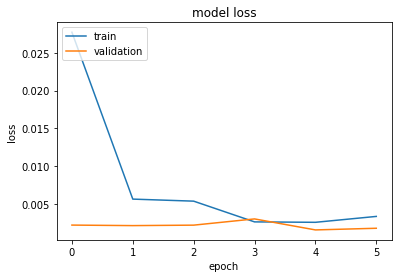

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

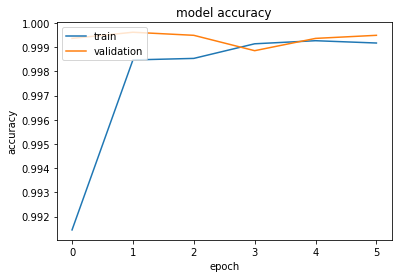

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
from keras.applications.densenet import DenseNet121

densenet = DenseNet121(
    include_top=False,
    input_shape=(254,254,3))
model = Sequential()
model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00005),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 32,
          validation_data = validation_generator,
          epochs = 6)

Epoch 1/6
984/984 [==============================] - 605s 605ms/step - loss: 0.0704 - accuracy: 0.9703 - val_loss: 0.0026 - val_accuracy: 0.9989
Epoch 2/6
984/984 [==============================] - 595s 605ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 3/6
984/984 [==============================] - 594s 603ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 5.0640e-04 - val_accuracy: 0.9997
Epoch 4/6
984/984 [==============================] - 593s 602ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 5/6
984/984 [==============================] - 596s 605ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 5.9941e-04 - val_accuracy: 0.9999
Epoch 6/6
984/984 [==============================] - 596s 606ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9996


In [ ]:
predictions = model.predict(test_generator)


In [ ]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.5) for x in predictions]

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      5137
           1       0.83      0.94      0.88      3480

    accuracy                           0.90      8617
   macro avg       0.89      0.90      0.89      8617
weighted avg       0.90      0.90      0.90      8617



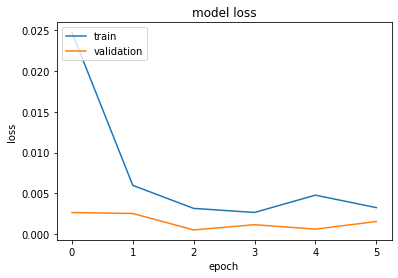

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

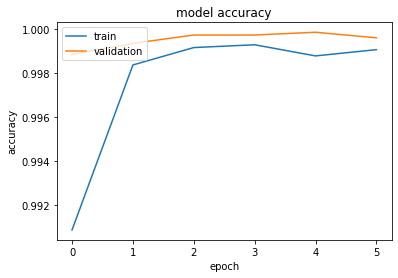

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
from keras.applications import DenseNet121
densenet_v2 = DenseNet121(
    include_top=False,
    input_shape=(254,254,3))
model = Sequential()
model.add(densenet_v2)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00005),
              metrics=['accuracy'])

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 32,
          validation_data = validation_generator, 
          validation_steps = validation_generator.samples // 32,
          epochs = 6)

Epoch 1/6
984/984 [==============================] - 746s 742ms/step - loss: 0.0626 - accuracy: 0.9764 - val_loss: 0.0041 - val_accuracy: 0.9989
Epoch 2/6
984/984 [==============================] - 723s 734ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0028 - val_accuracy: 0.9992
Epoch 3/6
984/984 [==============================] - 723s 735ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 4/6
984/984 [==============================] - 725s 736ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0395 - val_accuracy: 0.9834
Epoch 5/6
984/984 [==============================] - 730s 742ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0027 - val_accuracy: 0.9990
Epoch 6/6
984/984 [==============================] - 738s 750ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 8.8920e-04 - val_accuracy: 0.9997


In [ ]:
predictions = model.predict(test_generator)

In [ ]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.5) for x in predictions]

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      5137
           1       0.85      0.94      0.89      3480

    accuracy                           0.91      8617
   macro avg       0.90      0.91      0.91      8617
weighted avg       0.91      0.91      0.91      8617



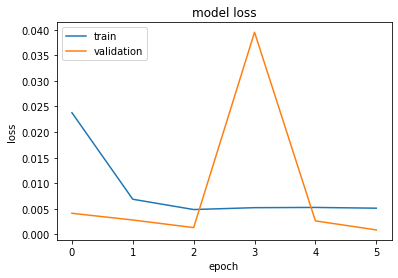

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

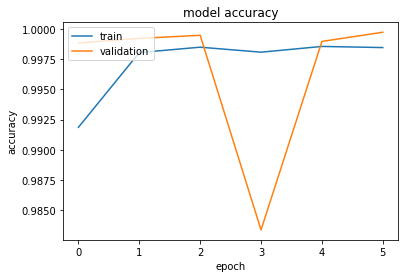

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [14]:
from keras.applications import VGG16
vgg16 = VGG16(
    include_top=False,
    input_shape=(350,350,3),
    classifier_activation="sigmoid")
model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00004),
              metrics=['accuracy'])

In [16]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 16,
          validation_data = validation_generator, 
          validation_steps = validation_generator.samples // 16,
          epochs = 6)

Epoch 1/6
2050/2050 [==============================] - 2253s 1s/step - loss: 0.1398 - accuracy: 0.9492 - val_loss: 0.0468 - val_accuracy: 0.9806
Epoch 2/6
2050/2050 [==============================] - 2210s 1s/step - loss: 0.0274 - accuracy: 0.9900 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 3/6
2050/2050 [==============================] - 2195s 1s/step - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.0126 - val_accuracy: 0.9970
Epoch 4/6
2050/2050 [==============================] - 2187s 1s/step - loss: 0.0113 - accuracy: 0.9959 - val_loss: 0.0075 - val_accuracy: 0.9976
Epoch 5/6
2050/2050 [==============================] - 2181s 1s/step - loss: 0.0329 - accuracy: 0.9908 - val_loss: 0.0079 - val_accuracy: 0.9970
Epoch 6/6
2050/2050 [==============================] - 2183s 1s/step - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0055 - val_accuracy: 0.9983


In [17]:
predictions = model.predict(test_generator)


In [18]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.5) for x in predictions]

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5137
           1       0.90      0.72      0.80      3480

    accuracy                           0.85      8617
   macro avg       0.87      0.83      0.84      8617
weighted avg       0.86      0.85      0.85      8617



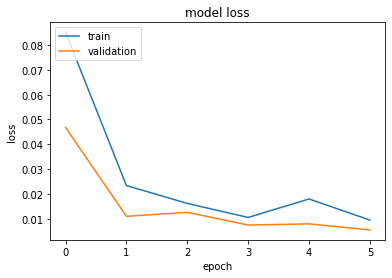

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

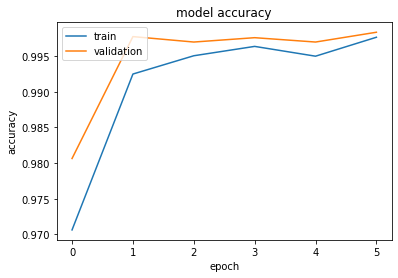

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [11]:
from keras.applications import ResNet101

resnet = ResNet101(
    include_top=False,
    input_shape=(350,350,3))
model = Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

171450368/171446536 [==============================] - 4s 0us/step


In [12]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00004),
              metrics=['accuracy'])

In [13]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 16,
          validation_data = validation_generator, 
          validation_steps = validation_generator.samples // 16,
          epochs = 6)

Epoch 1/6
  20/2050 [..............................] - ETA: 50:57 - loss: 0.5123 - accuracy: 0.7313

KeyboardInterrupt: ignored

In [ ]:
predictions = model.predict(test_generator)


In [ ]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.5) for x in predictions]

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      5137
           1       0.77      0.98      0.86      3480

    accuracy                           0.87      8617
   macro avg       0.87      0.89      0.87      8617
weighted avg       0.90      0.87      0.87      8617



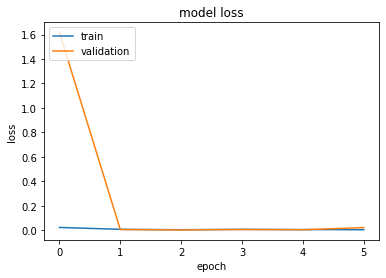

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

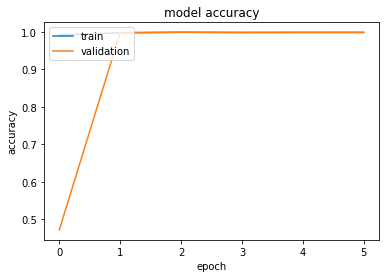

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [11]:
from keras.applications import DenseNet121

densenet_v2 = DenseNet121(
    include_top=False,
    input_shape=(350,350,3))
model = Sequential()
model.add(densenet_v2)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))



29089792/29084464 [==============================] - 0s 0us/step


In [19]:
from keras.optimizers import Adam, SGD, RMSprop
model.compile(loss='binary_crossentropy',
              #optimizer=Adam(lr=0.00004),
              optimizer=RMSprop(lr=0.00007),
              metrics=['accuracy'])

In [20]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 16,
          validation_data = validation_generator,
          epochs = 5)   

Epoch 1/5
2050/2050 [==============================] - 1194s 574ms/step - loss: 0.0133 - accuracy: 0.9980 - val_loss: 0.0038 - val_accuracy: 0.9980
Epoch 2/5
2050/2050 [==============================] - 1169s 570ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 3/5
2050/2050 [==============================] - 1167s 569ms/step - loss: 0.0125 - accuracy: 0.9982 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 4/5
2050/2050 [==============================] - 1168s 570ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 0.0249 - val_accuracy: 0.9919
Epoch 5/5
2050/2050 [==============================] - 1163s 567ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.0065 - val_accuracy: 0.9992


In [21]:
preds = model.predict(validation_generator,verbose=1)


411/411 [==============================] - 46s 108ms/step


In [22]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
val_labels=validation_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.5) for x in preds]

# get the classification report
print(classification_report(val_labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4169
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      6561
   macro avg       1.00      1.00      1.00      6561
weighted avg       1.00      1.00      1.00      6561



In [23]:
predictions = model.predict(test_generator)


In [24]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data

# get the class with highest probability for each sample
y_pred = [1 * (x[0]>=0.1) for x in predictions]

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      5137
           1       0.75      0.99      0.86      3480

    accuracy                           0.87      8617
   macro avg       0.87      0.89      0.87      8617
weighted avg       0.90      0.87      0.87      8617

